In [44]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import itertools
from pmdarima import auto_arima

from parser.loans_volume_msp import get_measures, get_loans_volume_msp_df
from data_transform.transform_df import transform_df_to_format

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

In [49]:
def mape( actual , pred ): 
    actual, pred = np.array(actual), np.array(pred)
    actual_safe = np.where(actual == 0, 1e-10, actual)
    return np.mean(np.abs((actual - pred) / actual_safe))*100

def region_predict(key, value):
    # временная заглушка
    df = transform_df_to_format(get_loans_volume_msp_df(2019, 2024, spikes_remove=False, measure_id=key))
    # Извлекаем год из столбца "Отчетный период"
    df['date'] = df['Отчетный период'].str.extract(r'(\d{4})').astype(int)
    # Формируем новый столбец "Дата" в формате YYYY-MM
    df['date'] = df['date'].astype(str) + '-' + df['month_n'].astype(str)
    df['date'] = pd.to_datetime(df['date'])
    # Удаляем временные столбцы
    df = df[['date', 'msp_loans_volume']]
    df = df.reset_index()
    df = df.drop('index', axis = 1)
    train_size = int(0.85 * len(df))
    test_size = len(df) - train_size
    split_date = df['date'].iloc[train_size]
    train = df[df['date']<split_date]
    test = df[df['date']>=split_date]
    # Делаем из датафреймов серии
    trn_ser = train.copy()
    trn_ser.set_index(keys='date', drop=True, inplace=True)
    trn_ser = trn_ser.squeeze(axis=1)
    tst_ser = test.copy()
    tst_ser.set_index(keys='date', drop=True, inplace=True)
    tst_ser = tst_ser.squeeze(axis=1)
    # Подбор параметров
    parameter_search = auto_arima(trn_ser, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal = True,
                         d = None, D = 1, trace = True, error_action ='ignore', suppress_warnings = True,  stepwise = True,
                         trend='ct', with_intercept=True) 
    s_ord = parameter_search.seasonal_order
    pdq = parameter_search.order
    # ОБУЧЕНИЕ МОДЕЛИ
    model = SARIMAX(trn_ser, order=pdq, seasonal_order=s_ord, trend='ct' , measurement_error=True, enforce_stationarity=True, enforce_invertibility=True ) 
    model_fit = model.fit() 
    pred = model_fit.get_prediction(start=split_date, end='2026-03-01', dynamic=False)
    vol_diff_pred = pred.predicted_mean
    test_pred = vol_diff_pred[0:test_size]
    mp = mape(tst_ser.values, test_pred.values)
    print(mp)
    plt.figure(figsize=(12, 4))
    plt.plot(df['date'], df['msp_loans_volume'].values/ 1e6)
    plt.plot(vol_diff_pred / 1e6)
    plt.xlabel('date')
    plt.ylabel('Объем кредитов, трлн руб.')
    plt.title(value)
    plt.grid(True)
    plt.show()

In [50]:
regions = get_measures()

for key,value in regions.items():
    print(key, ' - ', value)


22  -  Российская Федерация
23  -  Центральный федеральный округ
24  -  Белгородская область
25  -  Брянская область
26  -  Владимирская область
27  -  Воронежская область
28  -  Ивановская область
29  -  Калужская область
30  -  Костромская область
31  -  Курская область
32  -  Липецкая область
33  -  Московская область
34  -  Орловская область
35  -  Рязанская область
36  -  Смоленская область
37  -  Тамбовская область
38  -  Тверская область
39  -  Тульская область
40  -  Ярославская область
41  -  г. Москва
42  -  Северо-Западный федеральный округ
43  -  Республика Карелия
44  -  Республика Коми
45  -  Архангельская область
46  -  Архангельская область, в том числе Ненецкий автономный округ
47  -  Архангельская область без данных по Ненецкому автономному округу
48  -  Вологодская область
49  -  Калининградская область
50  -  Ленинградская область
51  -  Мурманская область
52  -  Новгородская область
53  -  Псковская область
54  -  г. Санкт-Петербург
55  -  Южный федеральный округ
5

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1130.054, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1144.958, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1126.684, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1131.132, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1144.958, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1136.845, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1124.149, Time=0.29 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1126.137, Time=0.46 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1127.681, Time=0.27 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1131.703, Time=0.17 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1126.248, Time=0.32 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1126.041, Time=0.38 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1127.939, Time=0.22 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=1127.356, Time=0.54 sec
 ARIMA(1,0,0)(2,1,0

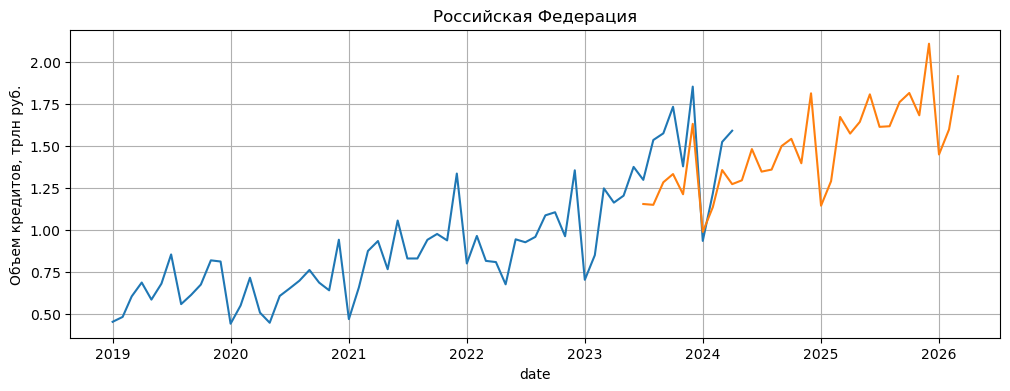

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1080.203, Time=0.19 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1095.891, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1073.205, Time=0.33 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1082.309, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1095.891, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1091.090, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1075.410, Time=0.20 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1076.245, Time=0.18 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1077.748, Time=0.17 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1077.354, Time=0.33 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1077.842, Time=0.06 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1075.700, Time=0.10 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1075.859, Time=0.12 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1077.238, Time=0.08 sec
 ARIMA(2,0,1)(1,1,0

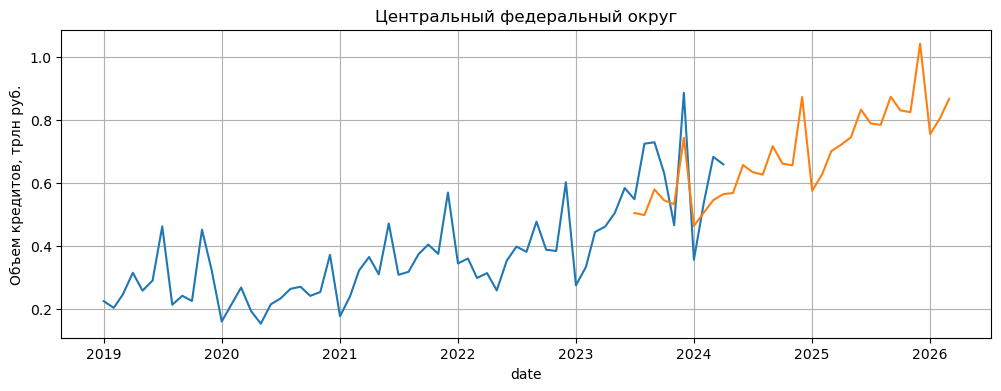

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1002.608, Time=0.47 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1008.711, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1006.848, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1006.885, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1008.711, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1011.234, Time=0.09 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1002.202, Time=0.63 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1000.325, Time=0.60 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1002.140, Time=0.95 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1007.131, Time=0.25 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=1001.950, Time=0.75 sec
 ARIMA(1,0,2)(1,1,0)[12] intercept   : AIC=1001.378, Time=0.68 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1005.622, Time=0.20 sec
 ARIMA(0,0,2)(1,1,0)[12]

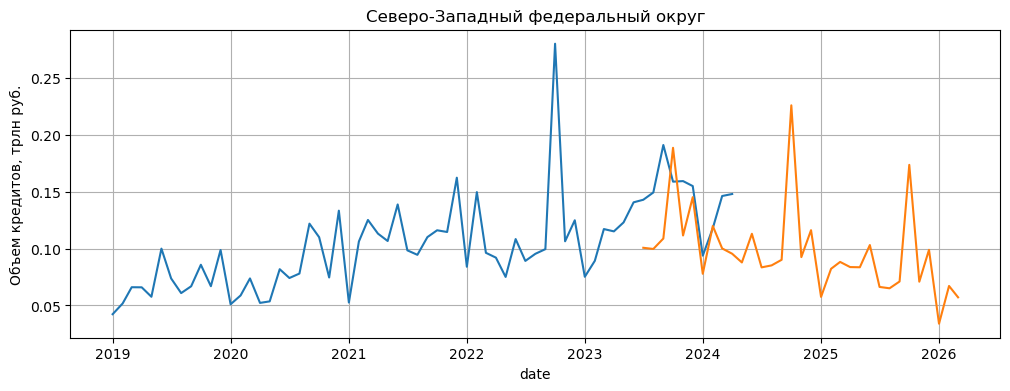

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=916.257, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=920.528, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=912.637, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=914.429, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=920.528, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=919.279, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=913.915, Time=0.17 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=915.271, Time=0.17 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=913.912, Time=0.10 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=915.905, Time=0.28 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=913.213, Time=0.07 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=914.909, Time=0.13 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=914.713, Time=0.14 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=913.326, Time=0.10 sec
 ARIMA(2,0,1)(1,1,0)[12] intercep

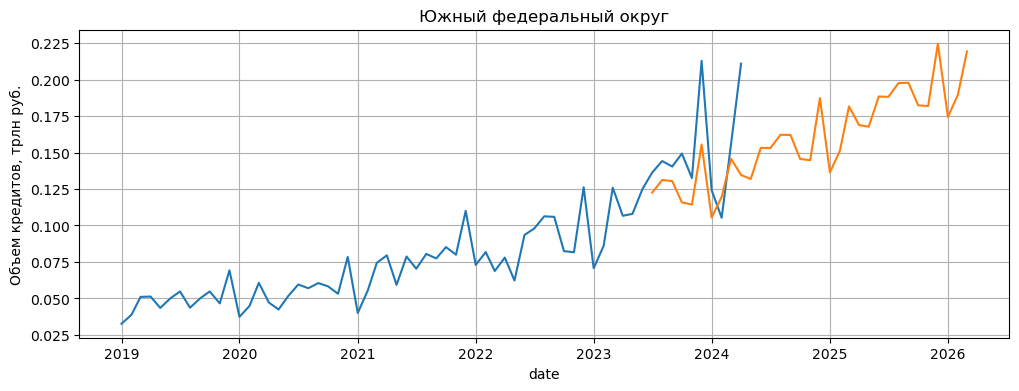

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=829.832, Time=0.56 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=834.434, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=829.878, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=831.165, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=834.434, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=835.257, Time=0.09 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=832.445, Time=0.54 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=832.521, Time=0.34 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=830.451, Time=0.39 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=834.500, Time=0.44 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=829.629, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=835.039, Time=0.06 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=831.130, Time=0.39 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=829.387, Time=0.85 sec
 ARIMA(1,0,0)(1,1,2)[12] intercep

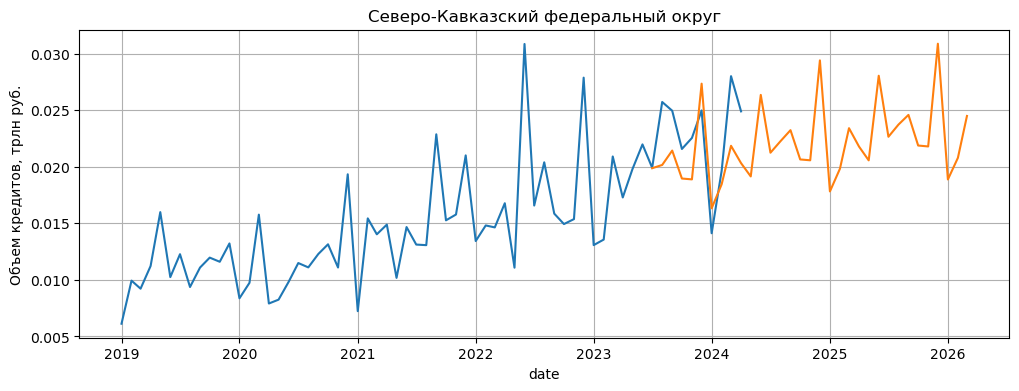

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=965.291, Time=0.13 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=981.251, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=960.567, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=967.462, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=981.251, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=969.821, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=960.218, Time=0.28 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=958.333, Time=0.94 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=958.306, Time=0.88 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=963.090, Time=0.19 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=962.955, Time=0.26 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=967.710, Time=0.80 sec
 ARIMA(2,0,0)(1,1,2)[12] intercept   : AI

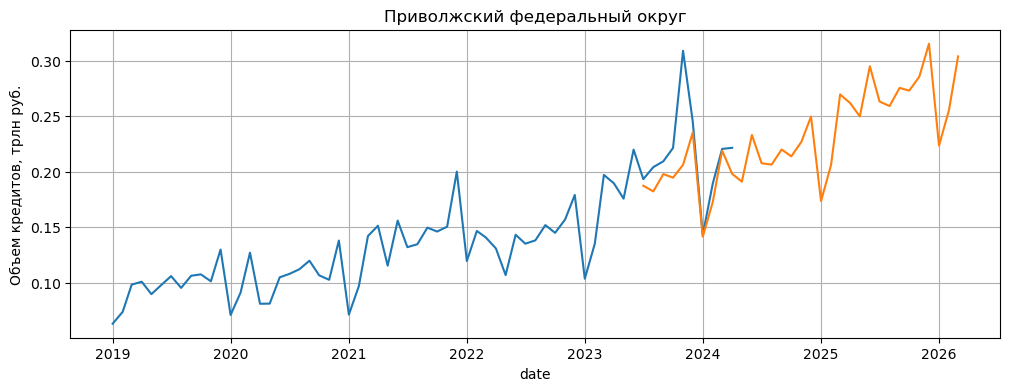

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=952.228, Time=0.39 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=955.484, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=952.042, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=953.926, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=955.484, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=955.207, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=953.710, Time=0.42 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=950.852, Time=0.67 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=952.848, Time=0.11 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=952.842, Time=0.79 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=952.849, Time=1.08 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=954.848, Time=0.20 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=954.445, Time=0.59 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=949.207, Time=0.48 sec
 ARIMA(0,0,0)(0,1,1)[12] intercep

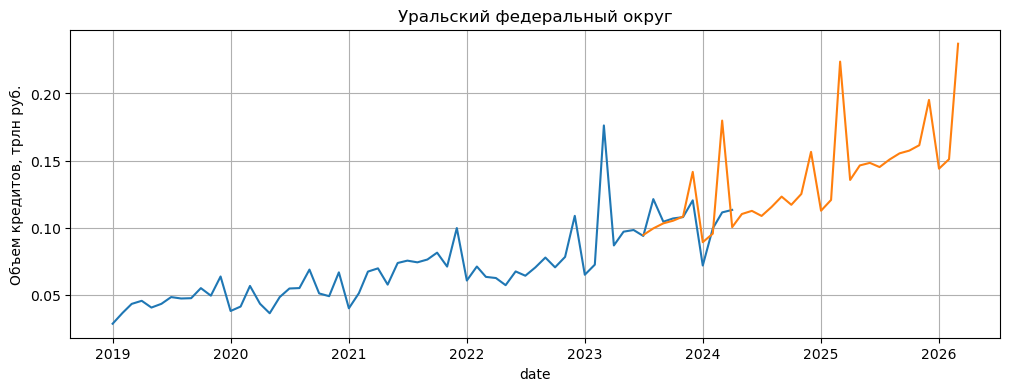

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=914.210, Time=0.89 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=928.196, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=914.654, Time=0.37 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=917.169, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=928.196, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=923.410, Time=0.14 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=909.806, Time=0.90 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=914.496, Time=0.23 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=914.320, Time=0.71 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=914.325, Time=0.77 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=915.783, Time=0.35 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=913.038, Time=0.41 sec
 ARIMA(1,0,1)(2,1,2)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=912.136, Time=1.09 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   

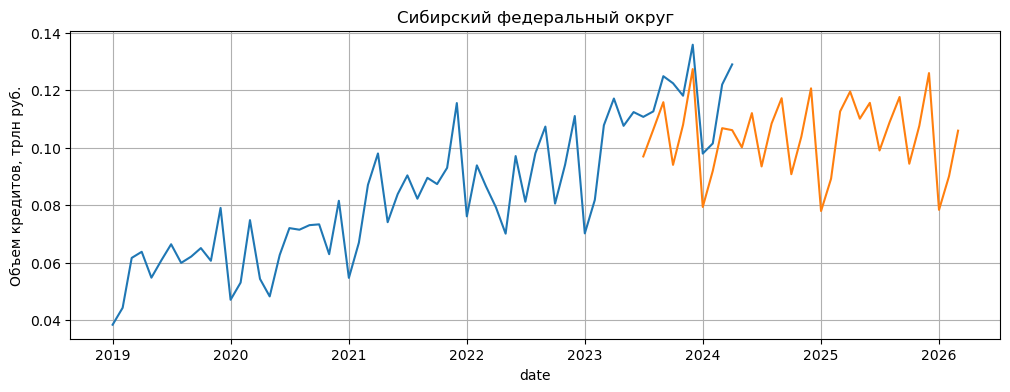

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=903.140, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=911.772, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=904.804, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=902.018, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=911.772, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=907.327, Time=0.10 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=903.816, Time=0.25 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=904.034, Time=0.32 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=901.846, Time=0.13 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=903.648, Time=0.40 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=905.646, Time=0.39 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=907.108, Time=0.35 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=903.032, Time=0.24 sec
 ARIMA(0,0,2)(1,1,0)[12] intercept   : AIC=902.673, Time=0.39 sec
 ARIMA(1,0,2)(1,1,0)[12] intercep

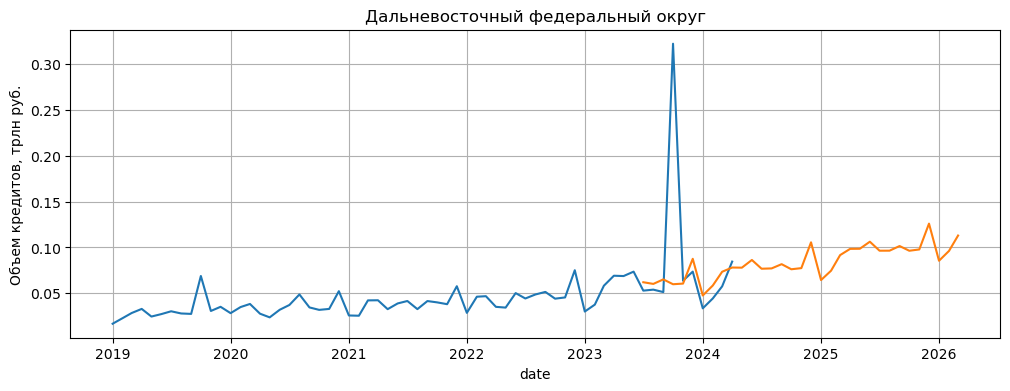

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=527.988, Time=0.61 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=530.962, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=524.930, Time=0.48 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=527.263, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=530.962, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=529.178, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=526.757, Time=0.86 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=526.764, Time=0.68 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=526.125, Time=0.50 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=528.791, Time=1.32 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=527.195, Time=0.32 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=526.338, Time=0.56 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=526.701, Time=0.59 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=526.106, Time=0.44 sec
 ARIMA(2,0,1)(1,1,0)[12] intercep

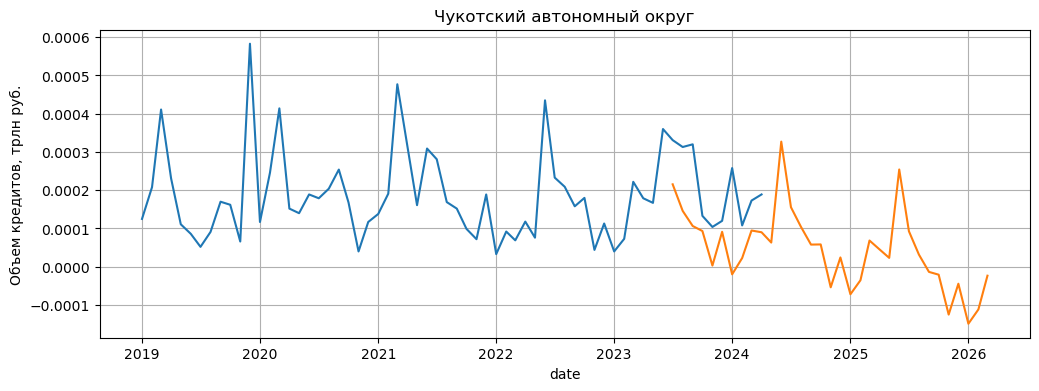

In [51]:
for key,value in regions.items():
    if key in [22, 23, 42, 55, 64, 72, 87, 95, 106, 117]:
        region_predict(key, value)